In [30]:
# !pip install dlib-19.23.0-cp39-cp39-win_amd64.whl
# !pip install cmake
# !pip install opencv-python
# !pip3 install face_recognition
# !pip install easyocr
# !pip install pytesseract
# !pip install rupasportread

In [14]:
import os
import io
import cv2
import easyocr
import requests
import numpy as np
import pytesseract
from PIL import Image
import face_recognition
import matplotlib.pyplot as plt
# from google.colab.files import upload
from rupasportread import pasp_read, resize
from skimage.filters import threshold_isodata

In [11]:
# подгрузим необходимые файлы (для google colab)
# upl = upload() 

In [22]:
photo_fold_path = r'DataForOCR/' # путь до папки с фотографиями

# **easyocr** - первый модуль для распознавания текста

In [65]:
def easyocr_recognition(image) -> str:   # Рассчитан на использование с GPU, на CPU работает медленнее

    reader = easyocr.Reader(["ru"])
    result = reader.readtext(image, 
                             detail=0,
                             paragraph=True)
                             
    return result 

# **pytesseract** - второй модуль для распознавания текста

In [13]:
pytesseract.pytesseract.tesseract_cmd = r'C:/Program Files/Tesseract-OCR/tesseract.exe' # путь к файлу tesseract.exe

In [47]:
def tesseract_recognition(image, 
                          lang:str='rus',
                          myconfig:str=r'--psm 6 --oem 3',
                          photo_fold_path:str=photo_fold_path) -> str: # Распознает текст быстрее при отсутствии GPU
    
    """ image argument could be both np.array and string (path to image)
    """

    if type(image)==np.ndarray:

        text = pytesseract.image_to_string(image, lang=lang)
        return text

    elif type(image)==str:
        text = pytesseract.image_to_string(Image.open(photo_fold_path+image), 
                                           lang=lang,
                                           config=myconfig)
        return text
    
    else:
        print('Not correct data type for image argument')

## **rupasportread** - третий модуль для распознавания текста

In [51]:
def ru_pass_read(img_name:str, 
                 photo_fold_path:str=photo_fold_path) -> dict: # данный модуль располагает как собственным аглоритмом предобработки,
                                                               # так и считывания текста. Дополнительные преобразования излишни.

                                                               # Качество считывания текста выше, чем у аналогов. Но для эксплуатации
                                                               # необходимо наличие на фото закодированной латиницей информации, которая
                                                               # отсутствует на предложенных к считыванию изображениях. 

    image = resize(photo_fold_path+img_name)
    text = pasp_read(image)

    return text

# **Face recognition** - модуль для распознавания лиц 

In [35]:
def face_rec(image:np.array) -> list: 

    face_coord = face_recognition.face_locations(image)

    if len(face_coord)>0:
      return face_coord  
    
    else: 
      print('Лицо на фото не обнаружено!')
      return face_coord

# **Предобработка** фото перед распознаванием текста

In [30]:
def adaptive_gaussian_binarization(img_name:str,
                     photo_fold_path:str=photo_fold_path,
                     block_size:int=45) -> np.array: 

  # reading 
  image = cv2.imread(photo_fold_path+img_name)

  # preprocessing - binarization
  img_gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

  binary = cv2.adaptiveThreshold(img_gray,255,cv2.ADAPTIVE_THRESH_GAUSSIAN_C,\
                                        cv2.THRESH_BINARY,block_size,30)
  return binary

In [31]:
def thresh_isodata_binarization(img_name:str,
                     photo_fold_path:str=photo_fold_path,
                     n:int=0) -> np.array:

  # reading 
  image = cv2.imread(photo_fold_path+img_name)

  # preprocessing - binarization
  thresh = threshold_isodata(image[:,:,0])
  bool_array = (image > thresh-n).astype(int)

  binary = (bool_array[:,:,0]*255).astype(np.uint8)

  return binary

In [159]:
# на практике личшие результаты были получены после обработки adaptive_gaussian_binarization
adapt_gauss_binary_dict = {img_name:adaptive_gaussian_binarization(img_name) for img_name in os.listdir(photo_fold_path)}
thr_isodata_binary_dict = {img_name:thresh_isodata_binarization(img_name) for img_name in os.listdir(photo_fold_path)}

In [160]:
def image_vis(image_list:list=adapt_gauss_binary_dict.values(),
              cmap:str='binary'):

  fig = plt.figure(figsize=(30, 20))

  for i, image in enumerate(image_list):
      fig.add_subplot(3,4,i+1)
      plt.imshow(Image.fromarray((image*255).astype(np.uint8)), cmap=cmap)

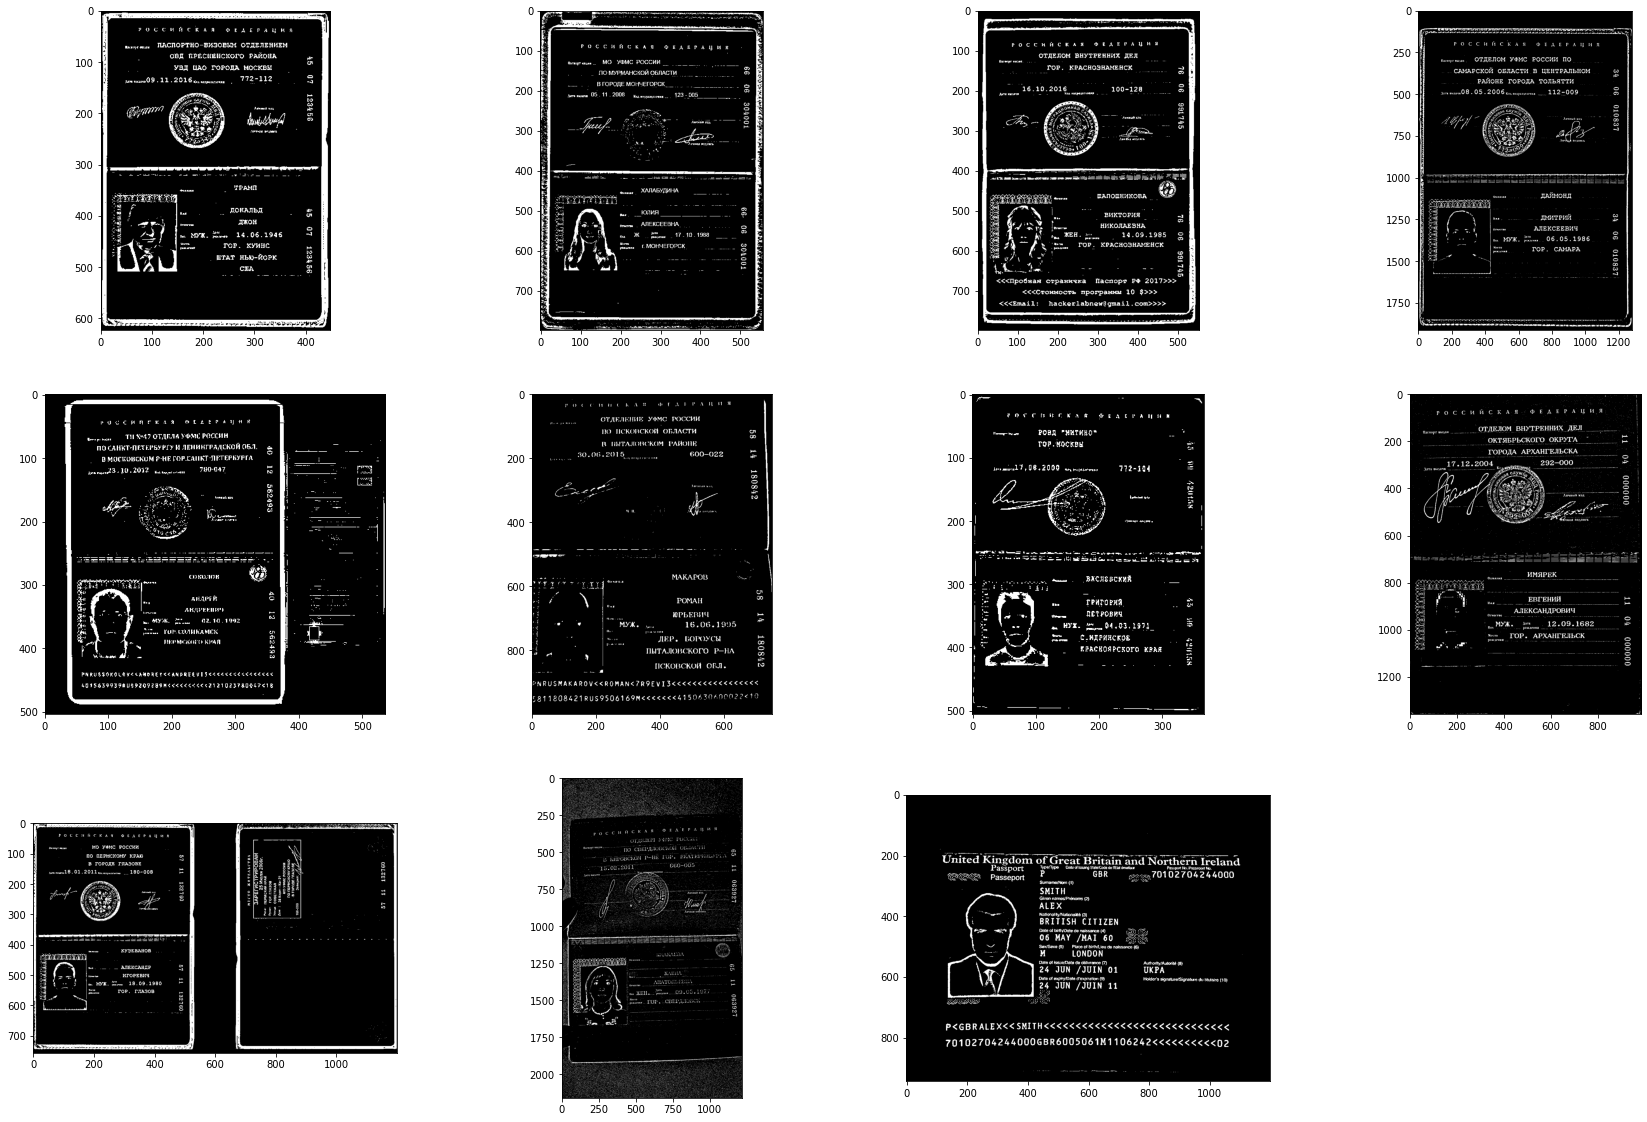

In [161]:
image_vis(adapt_gauss_binary_dict.values())

## **Распознание текста** при помощи модулей **easyocr** и **pytesseract** 

In [5]:
easyocr_image2text_dict = {key : easyocr_recognition(value) for key, value in adapt_gauss_binary_dict.items()}

NameError: name 'adapt_gauss_binary_dict' is not defined

In [ ]:
tesseract_image2text_dict = {key : tesseract_recognition(value) for key, value in adapt_gauss_binary_dict.items()}

## **Распознание текста** при помощи **API** сервиса

In [141]:
API_KEY = '############' # персональный API ключ к сервису 
API_URL = "https://api.ocr.space/parse/image"

In [135]:
def replace_unnecessary(string:str) -> str: # функция необходима для избавления от лишних подчеркиваний и  

      while '_' in string:
        string = string.replace('_','')

      while '-' in string:
        string = string.replace('-','')
      
      while '\r' in string:
        string = string.replace('\r','')
      
      return string

In [136]:
def responce2text(responce:dict):

    text = ' '.join([replace_unnecessary(word) for word in responce.json()['ParsedResults'][0]['ParsedText'].split('\n')])
    return text

In [150]:
def api_recognition(img_name:str,
                    api_key=API_KEY,
                    url_api=API_URL) -> str:

    try:
        # reading and binirization
        # binary = adaptive_gaussian_binarization(img_name)

        image = cv2.imread(photo_fold_path+img_name) # Считывание текста без предварительнной бинаризации происходит более качественно

        # preprocessing - compressing
        _, compressed_image = cv2.imencode(".jpg", image, [1, 90])
        file_bytes = io.BytesIO(compressed_image)

        # sending post reguest
        result = requests.post(url_api,
                        files = {"image.jpg": file_bytes},
                        data = {"apikey": api_key,
                                "language": ["rus"]})
        # cleaning text
        ps_txt = responce2text(result)
        return ps_txt
  
    except:
        print(f'Возникла проблема с распознанием {img_name}! ')

    

In [177]:
api_text_dict = {img_name:api_recognition(img_name) for img_name in os.listdir(photo_fold_path)}

## sort of **TEST**

In [11]:
image = resize('DataForOCR/0.jpeg')
# Image.fromarray(image)

In [37]:
pasp_read(image)

{'Surname': 'ЗДРИЛЮК',
 'Name': 'СЕРГЕЙ',
 'Mid': 'АНАТОЛИЕВИЧ',
 'Date': '23.07.1972',
 'Series': '3914',
 'Number': '935349'}

In [32]:
image = cv2.imread(photo_fold_path+'10.jpg')
threshold_isodata(image[:,:,0])

163